## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [14]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [15]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [16]:
#Number of rows in the dataset.
df.shape[0]

294478

c. The number of unique users in the dataset.

In [17]:
#Number of unique users in the dataset.
df["user_id"].nunique()

290584

d. The proportion of users converted.

In [18]:
#Proportion of users converted.
obs_converted_rate = df.query("converted == 1")["user_id"].nunique()/ \
    df["user_id"].nunique()
print('Proportion of users converted:', obs_converted_rate)

Proportion of users converted: 0.12104245244060237


e. The number of times the `new_page` and `treatment` don't match.

In [19]:
df.loc[((df.group != 'treatment') & (df.landing_page == 'new_page')) | ((df.group == 'treatment') & (df.landing_page == 'old_page'))].shape[0]

3893

In [20]:
#Number of times the new_page and treatment don't match
mismatch_count = df.query("group != 'treatment' \
         and landing_page == 'new_page' \
         or group == 'treatment' \
         and landing_page != 'new_page'"
        ).shape[0]
print('Number of times the new_page and treatment don\'t match:', mismatch_count)

Number of times the new_page and treatment don't match: 3893


f. Do any of the rows have missing values?

In [26]:
#Do any rows have missing values
is_missing_values = df.isnull().values.any()
print('Do any rows have missing values:', is_missing_values)

Do any rows have missing values: False


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [32]:
#Filter the dataframe where group and landing_page
#are treatment and language_page respectively.
df_tmt_newpage = df.query("group == 'treatment' \
                        and landing_page == 'new_page'"
                        )

In [33]:
#Filter the dataframe where group and landing_page
#are control and old_page respectively.
df_cntrl_oldpage = df.query("group == 'control' \
                        and landing_page == 'old_page'"
                        )

In [35]:
#Combine above treatment and control dataframes.
#This ensures we have clean data.
df2 = pd.concat([df_cntrl_oldpage, df_tmt_newpage], ignore_index=True)
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,864975,2017-01-21 01:52:26.210827,control,old_page,1
3,936923,2017-01-10 15:20:49.083499,control,old_page,0
4,719014,2017-01-17 01:48:29.539573,control,old_page,0


In [36]:
# Double Check all of the correct rows were removed - this should be 0
invalid_row_count = df2[((df2['group'] == 'treatment') == \
                             (df2['landing_page'] == 'new_page')) == \
                             False].shape[0]
print('Invalid Row count:', invalid_row_count)

Invalid Row count: 0


`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [37]:
#Unique users found in our cleaned up dataframe (df2).
unique_users = df2["user_id"].unique().shape[0]
print('Unique users in our cleaned dataframe df2:', unique_users)

Unique users in our cleaned dataframe df2: 290584


b. There is one **user_id** repeated in **df2**.  What is it?

In [74]:
#Retrieve the user_id that was duplicated.
duplicated_user_id = df2[df2.duplicated("user_id")] \
                        .user_id.to_string(index=False)
print('Duplicate user id:', duplicated_user_id)

Duplicate user id:  773192


c. What is the row information for the repeat **user_id**? 

In [75]:
#Row information for the duplicated user.
df2[df2.duplicated("user_id")]

,user_id,timestamp,group,landing_page,converted
146678,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [77]:
#Remove the duplicated user from the dataframe df2
df2.drop(df2[df2.duplicated("user_id")].index, inplace=True)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [88]:
#Probability of individual converting regardless of the page they receive
prob_converted =  df2.query("converted == 1")['user_id'].unique().shape[0] \
                  /df2["user_id"].unique().shape[0]
    
print('Probability of individual converted regardless of page:', prob_converted)


Probability of individual converted regardless of page: 0.11959708724499628


b. Given that an individual was in the `control` group, what is the probability they converted?

In [91]:
#Probability of control group individuals who converted.
cntrlgrp_converted_prob = df2.query("group == 'control' and  converted == 1")['user_id'].unique().shape[0] \
                          /df2.query("group == 'control'")['user_id'].unique().shape[0]
print('Probability of control group individuals who converted:',cntrlgrp_converted_prob)

Probability of control group individuals who converted: 0.1203863045004612


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [92]:
#Probability of treatment group individuals who converted.
trmtgrp_converted_prob = df2.query("group == 'treatment' and  converted == 1")['user_id'].unique().shape[0] \
                        /df2.query("group == 'treatment'")['user_id'].unique().shape[0]
print('Probability of treatment group individuals who converted:', trmtgrp_converted_prob)

Probability of treatment group individuals who converted: 0.11880806551510564


d. What is the probability that an individual received the new page?

In [94]:
#Probability that an individual received new page
newpage_prob = df2.query("landing_page == 'new_page'")['user_id'].unique().shape[0] \
                /df["user_id"].unique().shape[0]
print('Probability that an individual received new page:', newpage_prob)

Probability that an individual received new page: 0.5000619442226688


e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Your answer goes here.**
<br>
<br>

It is unlikely that the new page (treatment group) leads to more conversion, given that **12%** percent of individuals who received **old page (control group)** were converted, when compared to **11.8%** of individuals receiving **new page** were converted. With 0.2% percent difference in conversion, the older page is better then other.
<br>
<br>
For us to support this observation, it requires a quantifying answers to questions about samples of data.
<br>
<br>
Using statistical methods such as **Hypothesis testing** where we investigate a hypothesis. The result of this test allows us to interpert whether our assupmtion holds or whether the assumption has been violated.
<br>
<br>



<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [99]:
#Conversion rate under the null Pnew
pnew = df2.query("converted == 1").user_id.nunique() /df2.user_id.nunique()
print('Conversion rate under the null hypothesis (Pnew):',pnew)

Conversion rate under the null hypothesis (Pnew): 0.11959708724499628


b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [100]:
#We assume under the null hypothesis, both Pnew and Pold have equal success rate.
pold = pnew
print('Conversion rate under the null hypothesis (Pold):',pold)


Conversion rate under the null hypothesis (Pold): 0.11959708724499628


c. What is $n_{new}$, the number of individuals in the treatment group?

In [101]:
#Number of individuals in the treatment group.
nnew = df2.query("group == 'treatment'")['converted'].shape[0]
print('Number of individuals in the treatment group:', nnew)

Number of individuals in the treatment group: 145310


d. What is $n_{old}$, the number of individuals in the control group?

In [102]:
#Number of individuals in the control group
nold = df2.query("group == 'control'")['converted'].shape[0]
print('Number of individuals in the control group',nold)

Number of individuals in the control group 145274



e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [36]:
#Simulate nnew transactions with a conversion rate of pnew
new_page_converted = np.random.choice([0,1] , nnew, [1-pnew, pnew])
new_page_converted

array([0, 1, 1, ..., 0, 1, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [37]:
old_page_converted = np.random.choice([0,1] , nold, [1-pold, pold])
old_page_converted

array([1, 1, 1, ..., 0, 0, 1])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [38]:
pnew_rate = np.mean(new_page_converted)
pold_rate = np.mean(old_page_converted)

base_line_converted = (pnew_rate - pold_rate)
print(base_line_converted)


-0.000337361880639


In [39]:
df2_newpage = df2.query("landing_page == 'new_page'")
df_oldpage = df2.query("landing_page == 'old_page'")

In [40]:
np.mean(df2_newpage[['converted']] == 0)['converted']

0.88119193448489441

In [41]:
np.mean(df2_newpage[['converted']] == 1)['converted']

0.11880806551510564

In [42]:
np.mean(df2_newpage.converted)

0.11880806551510564

In [43]:
np.mean(df_oldpage[['converted']] == 1)['converted']

0.1203863045004612

In [44]:
np.mean(df_oldpage[['converted']] == 0)['converted']

0.87961369549953883

In [45]:
np.mean(df2[['converted']]==0)['converted']

0.88040291275500371

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [46]:
# p_diffs = []

# for _ in range(10000):
#     df_newsim = df2_newpage.sample(nnew, replace=True)
#     df_oldsim = df_oldpage.sample(nold, replace=True)
#     pnew_diff = np.mean(df_newsim.converted)
#     pold_diff = np.mean(df_oldsim.converted)
#     known_diff = pnew_diff - pold_diff
#     p_diffs.append(known_diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [47]:
#plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [48]:
# sim_diffs = np.array(p_diffs)
# null_values = np.random.normal(0, sim_diffs.std(), sim_diffs.size)

In [49]:
#plt.hist(null_values)
#plt.axvline(x=base_line_converted, color='red');
#plt.axvline(x=np.mean(null_values), color='black');

In [50]:
#(null_values > base_line_converted).mean()

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Put your answer here.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [51]:
import statsmodels.api as sm

convert_old = df2.query("converted == 1 and landing_page == 'old_page'").shape[0]
convert_new = df2.query("converted == 1 and landing_page == 'new_page'").shape[0]
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [52]:
n = n_old + n_new
pnull = obs_converted_rate
phat = pnew

significance = 0.05

#sm.stats.proportions_ztest(phat*n, n, pnull, alternative='larger')
#sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='larger')

stat, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], pnull, alternative='larger')

print('z_stat: %0.3f, p_value: %0.3f' % (stat, p_value))


if p_value > significance:
   print ("Fail to reject the null hypothesis - we have nothing else to say")
else:
   print ("Reject the null hypothesis - suggest the alternative hypothesis is true")


z_stat: -99.230, p_value: 1.000
Fail to reject the null hypothesis - we have nothing else to say


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [53]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,864975,2017-01-21 01:52:26.210827,control,old_page,1
3,936923,2017-01-10 15:20:49.083499,control,old_page,0
4,719014,2017-01-17 01:48:29.539573,control,old_page,0


In [54]:
df2['intercept'] = 1

In [55]:
#df2[['not_converted', 'converted']] = pd.get_dummies(df2['converted'])
df2[['not_converted', 'convert_dummy']] = pd.get_dummies(df2['converted'])

In [56]:
df2[['a_page', 'b_page']] = pd.get_dummies(df2['group'])

In [57]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,not_converted,convert_dummy,a_page,b_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,1,0
2,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,1,0
3,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,1,0,1,0
4,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,1,0,1,0


In [58]:
#df2 = df2.drop('not_converted', axis=1)

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [59]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,not_converted,convert_dummy,a_page,b_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,1,0
2,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,1,0
3,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,1,0,1,0
4,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,1,0,1,0


In [60]:
#df2 = df2.drop('a_page', axis=1)

In [61]:
from scipy import stats
stats.chisqprob = lambda chisq, df_new: stats.chi2.sf(chisq, df_new)

logit_mod = sm.Logit(df2['convert_dummy'], df2[['intercept', 'b_page']])
results = logit_mod.fit()
results.summary()


Optimization terminated successfully.
         Current function value: 448.424145
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          convert_dummy   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 06 Jun 2020   Pseudo R-squ.:              -1.405e-05
Time:                        00:36:25   Log-Likelihood:            -1.3030e+08
converged:                       True   LL-Null:                   -1.3030e+08
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
b_page        -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [62]:
#Control page - exponent
np.exp(0.0150)

1.0151130646157189

In [63]:
#Treatment page - exponent
1/np.exp(-0.0150)

1.0151130646157189

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Put your answer here.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [64]:
countries_df = pd.read_csv('countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [65]:
countries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
user_id    290584 non-null int64
country    290584 non-null object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


In [66]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 290584
Data columns (total 10 columns):
user_id          290584 non-null int64
timestamp        290584 non-null object
group            290584 non-null object
landing_page     290584 non-null object
converted        290584 non-null int64
intercept        290584 non-null int64
not_converted    290584 non-null uint8
convert_dummy    290584 non-null uint8
a_page           290584 non-null uint8
b_page           290584 non-null uint8
dtypes: int64(3), object(3), uint8(4)
memory usage: 16.6+ MB


In [67]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,not_converted,convert_dummy,a_page,b_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,1,0
2,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,1,0
3,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,1,0,1,0
4,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,1,0,1,0


In [68]:
countries_df.query("user_id == 851104")

,user_id,country
172334,851104,US


In [69]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,not_converted,convert_dummy,a_page,b_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,1,0
2,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,1,0
3,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,1,0,1,0
4,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,1,0,1,0


In [70]:
df2 = df2.merge(countries_df, how='inner', on='user_id', validate='1:1')

In [71]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,not_converted,convert_dummy,a_page,b_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,1,0,US
2,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,1,0,US
3,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,1,0,1,0,US
4,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,1,0,1,0,US


In [72]:
df2['country'].unique()

array(['US', 'CA', 'UK'], dtype=object)

In [73]:
df2[['CA', 'UK', 'USA']] = pd.get_dummies(df2['country'])

In [74]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,not_converted,convert_dummy,a_page,b_page,country,CA,UK,USA
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,1,0,US,0,0,1
2,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,1,0,US,0,0,1
3,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,1,0,1,0,US,0,0,1
4,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,1,0,1,0,US,0,0,1


In [75]:
from scipy import stats
stats.chisqprob = lambda chisq, df_new: stats.chi2.sf(chisq, df_new)

logit_mod = sm.Logit(df2['convert_dummy'], df2[['intercept', 'b_page', 'USA', 'UK']])
results = logit_mod.fit()
results.summary()


Optimization terminated successfully.
         Current function value: 448.436079
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          convert_dummy   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 06 Jun 2020   Pseudo R-squ.:              -4.067e-05
Time:                        00:36:26   Log-Likelihood:            -1.3031e+08
converged:                       True   LL-Null:                   -1.3030e+08
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
b_page        -0.0149      0.011     -1.307      0.191      -0.037       0.007
USA            0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix,f1_score

In [103]:
y = df2['convert_dummy']
X = df2[['a_page', 'b_page', 'CA', 'UK', 'USA']]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=27)


In [104]:
log_mod = LogisticRegression(solver='liblinear')
log_mod.fit(X_train, y_train)
y_pred = log_mod.predict(X_test)
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

0.0
0.0
0.881205155118
0.0


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[51213,     0],
       [ 6904,     0]])

In [109]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=20).fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)
print(accuracy_score(y_test, rfc_pred))

print(f1_score(y_test, rfc_pred))

print(recall_score(y_test, rfc_pred))
print(precision_score(y_test, rfc_pred))


0.881205155118
0.0
0.0
0.0


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [79]:
(y_pred == 0).sum()

58117

In [80]:
(y_pred == 1).sum()

0

In [81]:
(y_train == 0).sum()

204759

In [82]:
(y_train == 1).sum()

27708

In [83]:
(y_test == 0).sum()

51072

In [84]:
(y_test == 1).sum()

7045

In [85]:
y_pred.size

58117

In [86]:
from sklearn.metrics import classification_report
target_names =['not_converted', 'converted']
print(classification_report(y_test, y_pred, target_names=target_names))

               precision    recall  f1-score   support

not_converted       0.88      1.00      0.94     51072
    converted       0.00      0.00      0.00      7045

  avg / total       0.77      0.88      0.82     58117



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [87]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.878779014746


In [89]:
corr = df2.corr(method='pearson')

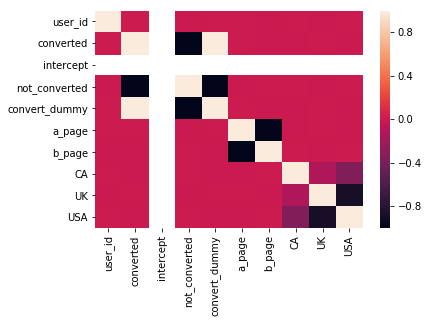

In [90]:
import seaborn as sns
sns.heatmap(corr)

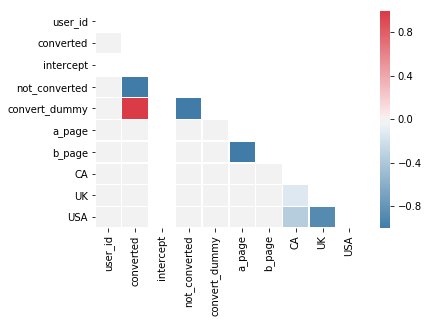

In [91]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(240, 10, as_cmap=True)
# Plotting the heatmap
sns.heatmap(corr, mask=mask, linewidths=.5, cmap=cmap, center=0)

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [88]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0